# Experiment Tracking with TensorBoard in PyTorch

In this notebook, we'll explore how to use TensorBoard for tracking and visualizing machine learning experiments in PyTorch. We'll train and compare three different models (TinyVGG, EfficientNetB0, and EfficientNetB2) on the CIFAR-100 dataset, and use TensorBoard to monitor their performance.


## Introduction to Experiment Tracking and TensorBoard

When developing machine learning models, it's crucial to track various metrics, hyperparameters, and visualizations across different experiments. This helps in:

1. **Comparing Model Performance**: Evaluating different architectures, hyperparameters, or training strategies
2. **Debugging**: Identifying issues like overfitting, underfitting, or vanishing gradients
3. **Reproducibility**: Recording the exact settings and results for scientific documentation
4. **Collaboration**: Sharing results and insights with team members

[TensorBoard](https://www.tensorflow.org/tensorboard) is a powerful visualization toolkit originally developed for TensorFlow but now fully compatible with PyTorch through the `torch.utils.tensorboard` module. It allows you to track and visualize:

- Scalar metrics (loss, accuracy)
- Model architecture
- Histograms of weights and gradients
- Embeddings and projections
- Images and audio samples
- Text outputs


## Notebook Setup

This notebook is designed to be run on Kaggle, which provides GPU acceleration and easy access to the CIFAR-100 dataset. Let's start by importing the necessary libraries and setting up our environment.


In [1]:
# Import necessary libraries
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import random
from torch.utils.tensorboard import SummaryWriter
import time
from datetime import datetime
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if GPU or MPS is available
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")


# Create a logs directory for TensorBoard
log_dir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir.mkdir(parents=True, exist_ok=True)
print(f"TensorBoard logs will be saved to: {log_dir}")

Using device: mps
TensorBoard logs will be saved to: logs/20250717-144931


## Loading and Preparing the CIFAR-100 Dataset

The CIFAR-100 dataset consists of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.

When running on Kaggle, the dataset is readily available. Let's load the dataset and prepare it for training:


In [2]:
# Define data transformations
# For training - we'll apply data augmentation
train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

# For testing - only normalize
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ]
)

train_data = datasets.CIFAR100(
    root="data", train=True, download=True, transform=train_transform
)

test_data = datasets.CIFAR100(
    root="data", train=False, download=True, transform=test_transform
)

# Set up DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device == "cuda" else False,
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device == "cuda" else False,
)

# Get class names
class_names = train_data.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Training images: {len(train_data)}")
print(f"Testing images: {len(test_data)}")

Number of classes: 100
Training images: 50000
Testing images: 10000


Let's visualize some examples from the dataset to get familiar with it:


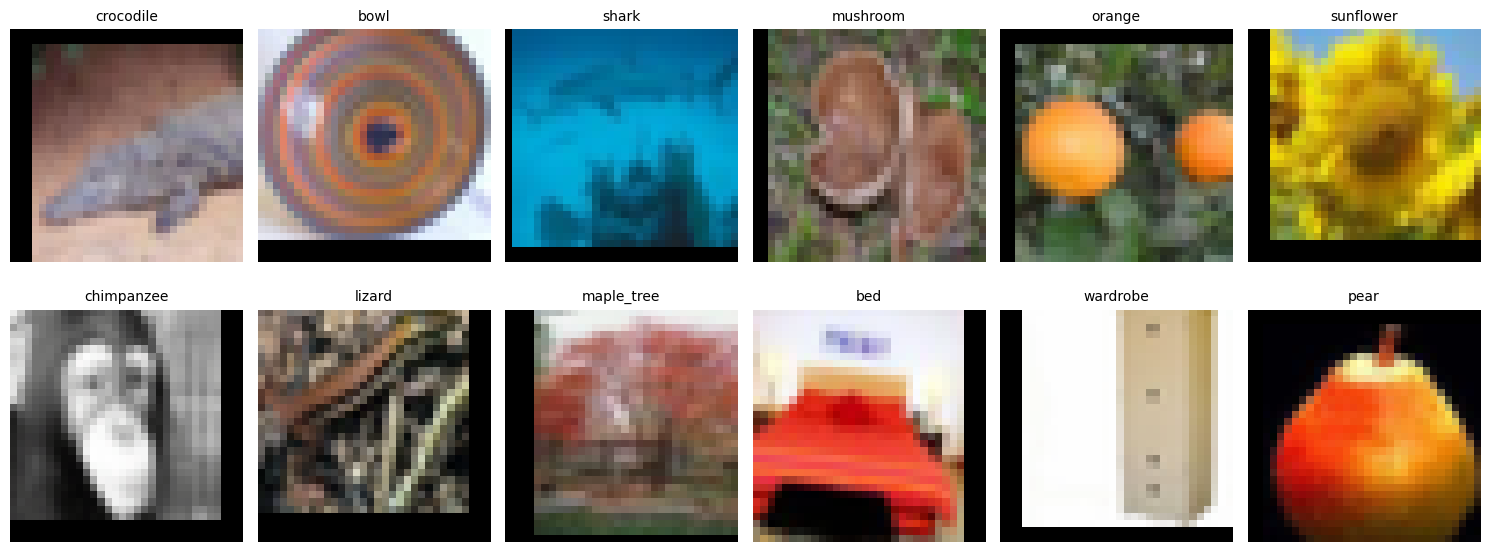

In [3]:
# Function to visualize images with their labels
def visualize_samples(dataloader, class_names, n_samples=12):
    # Get a batch of images
    images, labels = next(iter(dataloader))

    # Convert images from tensor to numpy array for plotting
    images = images.numpy()

    # Create a figure
    fig, axes = plt.subplots(nrows=2, ncols=n_samples // 2, figsize=(15, 6))
    axes = axes.flatten()

    # Plot each image with its label
    for i in range(n_samples):
        img = np.transpose(images[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array(
            [0.5071, 0.4867, 0.4408]
        )  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be in [0, 1]

        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]], fontsize=10)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize samples from the training dataset
visualize_samples(train_loader, class_names)

## Building the Models

We'll build and compare three different CNN architectures:

1. **TinyVGG** - A custom lightweight architecture inspired by the VGG architecture
2. **EfficientNetB0** - A pre-trained model known for its efficiency
3. **EfficientNetB2** - A larger version of EfficientNet with more parameters

Let's start by defining our TinyVGG model:


In [4]:
class TinyVGG(nn.Module):
    """
    A simplified VGG-like architecture with fewer parameters.

    Architecture:
    - Conv block 1: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Conv block 2: [Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool]
    - Classifier: [Flatten -> Linear -> ReLU -> Dropout -> Linear]
    """

    def __init__(self, input_shape=3, hidden_units=128, output_shape=100):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units * 2,
                out_channels=hidden_units * 2,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units * 2 * 8 * 8, out_features=hidden_units * 2
            ),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=hidden_units * 2, out_features=output_shape),
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

Now, let's set up the EfficientNet models using transfer learning. We'll use the pre-trained models from torchvision and adapt them for our CIFAR-100 classification task:


In [5]:
def create_effnet_model(model_name, num_classes):
    """
    Create and configure an EfficientNet model for fine-tuning on CIFAR-100.

    Args:
        model_name (str): Either 'efficientnet_b0' or 'efficientnet_b2'
        num_classes (int): Number of output classes (100 for CIFAR-100)

    Returns:
        model: Configured PyTorch model
    """
    if model_name == "efficientnet_b0":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    elif model_name == "efficientnet_b2":
        model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
    else:
        raise ValueError("Model name must be 'efficientnet_b0' or 'efficientnet_b2'")

    # Freeze the features
    # for param in model.features.parameters():
    #     param.requires_grad = False

    # Replace the classifier with a new one
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=in_features, out_features=num_classes),
    )

    return model

## Training and Evaluation Functions

Let's define the functions for training and evaluating our models. We'll use TensorBoard to track various metrics:


In [6]:
def train_step(model, dataloader, loss_fn, optimizer, device, epoch, writer):
    """Train the model for one epoch and log metrics to TensorBoard."""
    model.train()
    train_loss, train_acc = 0, 0

    # Create a progress bar
    progress_bar = tqdm(dataloader, desc=f"Training Epoch {epoch}")

    for batch, (X, y) in enumerate(progress_bar):
        # Move data to device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate metrics
        train_loss += loss.item()

        # Calculate accuracy (argmax gets the class with highest probability)
        y_pred_class = torch.argmax(y_pred, dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # Update progress bar with loss
        progress_bar.set_postfix(loss=loss.item())

    # Calculate average metrics
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    # Log to TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)

    # Log histograms of model parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            writer.add_histogram(f"Parameters/{name}", param, epoch)

    return train_loss, train_acc


def test_step(model, dataloader, loss_fn, device, epoch, writer):
    """Test the model and log metrics to TensorBoard."""
    model.eval()
    test_loss, test_acc = 0, 0

    # No gradient tracking needed for evaluation
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Move data to device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate the loss
            loss = loss_fn(y_pred, y)

            # Calculate and accumulate metrics
            test_loss += loss.item()

            # Calculate accuracy
            y_pred_class = torch.argmax(y_pred, dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Calculate average metrics
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    # Log to TensorBoard
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_acc, epoch)

    return test_loss, test_acc


def train_model(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    epochs,
    device,
    model_name,
    writer,
):
    """Train and evaluate a model for a given number of epochs and log metrics to TensorBoard."""
    # Create results dictionary to track metrics
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # Add the model architecture graph to TensorBoard
    sample_images, _ = next(iter(train_loader))
    writer.add_graph(model, sample_images.to(device))

    # Create a directory to save models
    models_dir = Path("models")
    models_dir.mkdir(exist_ok=True)

    # Training loop
    start_time = time.time()
    best_test_acc = 0.0

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print(f"\nEpoch: {epoch+1}/{epochs}")

        # Train step
        train_loss, train_acc = train_step(
            model, train_loader, loss_fn, optimizer, device, epoch, writer
        )

        # Test step
        test_loss, test_acc = test_step(
            model, test_loader, loss_fn, device, epoch, writer
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Print metrics
        print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        # Save the best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), models_dir / f"{model_name}_best.pth")
            print(f"New best model saved with accuracy: {best_test_acc:.4f}")

    # Calculate training time
    end_time = time.time()
    training_time = end_time - start_time

    # Log final metrics to TensorBoard as text
    writer.add_text(
        "Training Summary",
        f"Model: {model_name}\n"
        f"Best test accuracy: {best_test_acc:.4f}\n"
        f"Training time: {training_time:.2f} seconds",
        0,
    )

    print(
        f"Training completed in {training_time:.2f} seconds with best test accuracy: {best_test_acc:.4f}"
    )

    return results

## Experiment 1: TinyVGG Model

Now let's train our first model, TinyVGG, and track its performance using TensorBoard:


In [7]:
# Instantiate TinyVGG model
tinyvgg_model = TinyVGG(input_shape=3, hidden_units=64, output_shape=num_classes).to(
    device
)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tinyvgg_model.parameters(), lr=0.001)

# Create a TensorBoard writer for TinyVGG
tinyvgg_writer = SummaryWriter(log_dir / "TinyVGG")

# Train the model
EPOCHS = 20
print("Training TinyVGG model...")
tinyvgg_results = train_model(
    model=tinyvgg_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="tinyvgg",
    writer=tinyvgg_writer,
)

tinyvgg_writer.close()

Training TinyVGG model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 4.2883 | Train acc: 0.0420
Test loss: 3.8807 | Test acc: 0.1009
New best model saved with accuracy: 0.1009

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.9328 | Train acc: 0.0846
Test loss: 3.5977 | Test acc: 0.1518
New best model saved with accuracy: 0.1518

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.7421 | Train acc: 0.1138
Test loss: 3.3539 | Test acc: 0.1905
New best model saved with accuracy: 0.1905

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.6048 | Train acc: 0.1322
Test loss: 3.2372 | Test acc: 0.2143
New best model saved with accuracy: 0.2143

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.5020 | Train acc: 0.1523
Test loss: 3.0801 | Test acc: 0.2461
New best model saved with accuracy: 0.2461

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.4042 | Train acc: 0.1663
Test loss: 2.9469 | Test acc: 0.2698
New best model saved with accuracy: 0.2698

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.3175 | Train acc: 0.1811
Test loss: 2.8370 | Test acc: 0.2849
New best model saved with accuracy: 0.2849

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:04<?, ?it/s]

Train loss: 3.2436 | Train acc: 0.1909
Test loss: 2.7877 | Test acc: 0.2977
New best model saved with accuracy: 0.2977

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.1758 | Train acc: 0.2064
Test loss: 2.7117 | Test acc: 0.3027
New best model saved with accuracy: 0.3027

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:04<?, ?it/s]

Train loss: 3.1219 | Train acc: 0.2150
Test loss: 2.6490 | Test acc: 0.3143
New best model saved with accuracy: 0.3143

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.0763 | Train acc: 0.2236
Test loss: 2.5851 | Test acc: 0.3314
New best model saved with accuracy: 0.3314

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.0281 | Train acc: 0.2332
Test loss: 2.5732 | Test acc: 0.3365
New best model saved with accuracy: 0.3365

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.9897 | Train acc: 0.2401
Test loss: 2.5247 | Test acc: 0.3431
New best model saved with accuracy: 0.3431

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.9436 | Train acc: 0.2458
Test loss: 2.5152 | Test acc: 0.3440
New best model saved with accuracy: 0.3440

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.9049 | Train acc: 0.2566
Test loss: 2.4491 | Test acc: 0.3586
New best model saved with accuracy: 0.3586

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:04<?, ?it/s]

Train loss: 2.8561 | Train acc: 0.2666
Test loss: 2.4021 | Test acc: 0.3754
New best model saved with accuracy: 0.3754

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.8239 | Train acc: 0.2704
Test loss: 2.3612 | Test acc: 0.3712

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.7914 | Train acc: 0.2773
Test loss: 2.3408 | Test acc: 0.3798
New best model saved with accuracy: 0.3798

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.7441 | Train acc: 0.2848
Test loss: 2.3066 | Test acc: 0.3885
New best model saved with accuracy: 0.3885

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.7247 | Train acc: 0.2908
Test loss: 2.2879 | Test acc: 0.4034
New best model saved with accuracy: 0.4034
Training completed in 1095.78 seconds with best test accuracy: 0.4034


## Experiment 2: EfficientNetB0 Model

Next, let's train an EfficientNetB0 model using transfer learning:


In [8]:
# Instantiate EfficientNetB0 model
effnetb0_model = create_effnet_model("efficientnet_b0", num_classes).to(device)

# Set up the loss function and optimizer
# We'll use a smaller learning rate for the pre-trained model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb0_model.parameters(), lr=0.0005)

# Create a TensorBoard writer for EfficientNetB0
effnetb0_writer = SummaryWriter(log_dir / "EfficientNetB0")

# Train the model
print("Training EfficientNetB0 model...")
effnetb0_results = train_model(
    model=effnetb0_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="efficientnetb0",
    writer=effnetb0_writer,
)

effnetb0_writer.close()

Training EfficientNetB0 model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.2712 | Train acc: 0.2187
Test loss: 2.3371 | Test acc: 0.3817
New best model saved with accuracy: 0.3817

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.2020 | Train acc: 0.4124
Test loss: 1.9111 | Test acc: 0.4764
New best model saved with accuracy: 0.4764

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.8664 | Train acc: 0.4871
Test loss: 1.7563 | Test acc: 0.5141
New best model saved with accuracy: 0.5141

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.7005 | Train acc: 0.5265
Test loss: 1.7285 | Test acc: 0.5297
New best model saved with accuracy: 0.5297

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.5283 | Train acc: 0.5687
Test loss: 1.6127 | Test acc: 0.5577
New best model saved with accuracy: 0.5577

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.3948 | Train acc: 0.5992
Test loss: 1.5509 | Test acc: 0.5772
New best model saved with accuracy: 0.5772

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.2943 | Train acc: 0.6249
Test loss: 1.6030 | Test acc: 0.5722

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.2903 | Train acc: 0.6260
Test loss: 1.5550 | Test acc: 0.5727

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.1164 | Train acc: 0.6696
Test loss: 1.5232 | Test acc: 0.5929
New best model saved with accuracy: 0.5929

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.0196 | Train acc: 0.6928
Test loss: 1.5055 | Test acc: 0.5979
New best model saved with accuracy: 0.5979

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.9595 | Train acc: 0.7100
Test loss: 1.5394 | Test acc: 0.5934

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.8624 | Train acc: 0.7331
Test loss: 1.5384 | Test acc: 0.5973

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:04<?, ?it/s]

Train loss: 0.8150 | Train acc: 0.7499
Test loss: 1.5299 | Test acc: 0.6033
New best model saved with accuracy: 0.6033

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.7705 | Train acc: 0.7598
Test loss: 1.6116 | Test acc: 0.5938

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.6960 | Train acc: 0.7821
Test loss: 1.6225 | Test acc: 0.5976

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.6406 | Train acc: 0.7963
Test loss: 1.6296 | Test acc: 0.6065
New best model saved with accuracy: 0.6065

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.6151 | Train acc: 0.8043
Test loss: 1.6763 | Test acc: 0.5948

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.5610 | Train acc: 0.8204
Test loss: 1.6995 | Test acc: 0.6055

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.5128 | Train acc: 0.8352
Test loss: 1.6968 | Test acc: 0.6094
New best model saved with accuracy: 0.6094

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.5070 | Train acc: 0.8374
Test loss: 1.8257 | Test acc: 0.5901
Training completed in 1786.00 seconds with best test accuracy: 0.6094


## Experiment 3: EfficientNetB2 Model

Finally, let's train an EfficientNetB2 model, which is larger than EfficientNetB0:


In [9]:
# Instantiate EfficientNetB2 model
effnetb2_model = create_effnet_model("efficientnet_b2", num_classes).to(device)

# Set up the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr=0.0005)

# Create a TensorBoard writer for EfficientNetB2
effnetb2_writer = SummaryWriter(log_dir / "EfficientNetB2")

# Train the model
print("Training EfficientNetB2 model...")
effnetb2_results = train_model(
    model=effnetb2_model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    model_name="efficientnetb2",
    writer=effnetb2_writer,
)

effnetb2_writer.close()

Training EfficientNetB2 model...

Epoch: 1/20


Training Epoch 0:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 3.3858 | Train acc: 0.2009
Test loss: 2.3627 | Test acc: 0.3899
New best model saved with accuracy: 0.3899

Epoch: 2/20


Training Epoch 1:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 2.1777 | Train acc: 0.4199
Test loss: 1.7902 | Test acc: 0.5043
New best model saved with accuracy: 0.5043

Epoch: 3/20


Training Epoch 2:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.8011 | Train acc: 0.5043
Test loss: 1.6280 | Test acc: 0.5441
New best model saved with accuracy: 0.5441

Epoch: 4/20


Training Epoch 3:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.5931 | Train acc: 0.5530
Test loss: 1.5484 | Test acc: 0.5722
New best model saved with accuracy: 0.5722

Epoch: 5/20


Training Epoch 4:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.4274 | Train acc: 0.5946
Test loss: 1.4872 | Test acc: 0.5832
New best model saved with accuracy: 0.5832

Epoch: 6/20


Training Epoch 5:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.3031 | Train acc: 0.6250
Test loss: 1.4586 | Test acc: 0.5958
New best model saved with accuracy: 0.5958

Epoch: 7/20


Training Epoch 6:   0%|          | 0/391 [00:04<?, ?it/s]

Train loss: 1.1864 | Train acc: 0.6527
Test loss: 1.4324 | Test acc: 0.5987
New best model saved with accuracy: 0.5987

Epoch: 8/20


Training Epoch 7:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 1.0964 | Train acc: 0.6782
Test loss: 1.4700 | Test acc: 0.6007
New best model saved with accuracy: 0.6007

Epoch: 9/20


Training Epoch 8:   0%|          | 0/391 [00:04<?, ?it/s]

Train loss: 0.9973 | Train acc: 0.7031
Test loss: 1.4676 | Test acc: 0.6048
New best model saved with accuracy: 0.6048

Epoch: 10/20


Training Epoch 9:   0%|          | 0/391 [00:04<?, ?it/s]

Train loss: 0.9540 | Train acc: 0.7110
Test loss: 1.4856 | Test acc: 0.6022

Epoch: 11/20


Training Epoch 10:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.8647 | Train acc: 0.7369
Test loss: 1.4868 | Test acc: 0.6107
New best model saved with accuracy: 0.6107

Epoch: 12/20


Training Epoch 11:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.7798 | Train acc: 0.7621
Test loss: 1.5041 | Test acc: 0.6145
New best model saved with accuracy: 0.6145

Epoch: 13/20


Training Epoch 12:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.7194 | Train acc: 0.7788
Test loss: 1.5235 | Test acc: 0.6094

Epoch: 14/20


Training Epoch 13:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.6681 | Train acc: 0.7929
Test loss: 1.5634 | Test acc: 0.6104

Epoch: 15/20


Training Epoch 14:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.7364 | Train acc: 0.7762
Test loss: 1.7702 | Test acc: 0.5857

Epoch: 16/20


Training Epoch 15:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.7951 | Train acc: 0.7576
Test loss: 1.7518 | Test acc: 0.5949

Epoch: 17/20


Training Epoch 16:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.6084 | Train acc: 0.8090
Test loss: 1.8013 | Test acc: 0.6057

Epoch: 18/20


Training Epoch 17:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.5481 | Train acc: 0.8277
Test loss: 1.6972 | Test acc: 0.6076

Epoch: 19/20


Training Epoch 18:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.4811 | Train acc: 0.8458
Test loss: 2.3436 | Test acc: 0.6067

Epoch: 20/20


Training Epoch 19:   0%|          | 0/391 [00:03<?, ?it/s]

Train loss: 0.4721 | Train acc: 0.8510
Test loss: 1.9531 | Test acc: 0.6011
Training completed in 3193.27 seconds with best test accuracy: 0.6145


## Visualizing Results in TensorBoard

Now that we've trained our models and logged metrics to TensorBoard, let's learn how to visualize these results:


In [10]:
print(f"To view TensorBoard locally, run the following command in your terminal:")
print(f"tensorboard --logdir={log_dir}")

To view TensorBoard locally, run the following command in your terminal:
tensorboard --logdir=logs/20250717-144931


## Analyzing TensorBoard Outputs

TensorBoard provides various visualization tools to help understand model performance. Here's what you can find in the TensorBoard interface:

### 1. Scalars

The SCALARS tab shows metrics like loss and accuracy over time. This helps you:

- Compare training and validation performance
- Identify overfitting (when training accuracy continues to improve while validation stagnates)
- Detect underfitting (when both training and validation accuracy are low)

### 2. Graphs

The GRAPHS tab displays the computational graph of your models, helping you understand the architecture and data flow.

### 3. Distributions and Histograms

The DISTRIBUTIONS and HISTOGRAMS tabs show how weights and biases change during training, which helps:

- Detect vanishing or exploding gradients
- Understand weight distributions

### 4. Images

The IMAGES tab can display sample images and visualizations.

### 5. Text

The TEXT tab shows any text logs you've added, like hyperparameter configurations or training summaries.

### Tips for Using TensorBoard

- Compare different runs with different hyperparameters
- Use smoothing to reduce noise in the graphs
- Download graphs and visualizations for reports
- Use the "relative" time mode to align runs at their start points


## Creating a Custom Visualization for Model Comparison

Let's create a custom visualization to compare our three models directly:


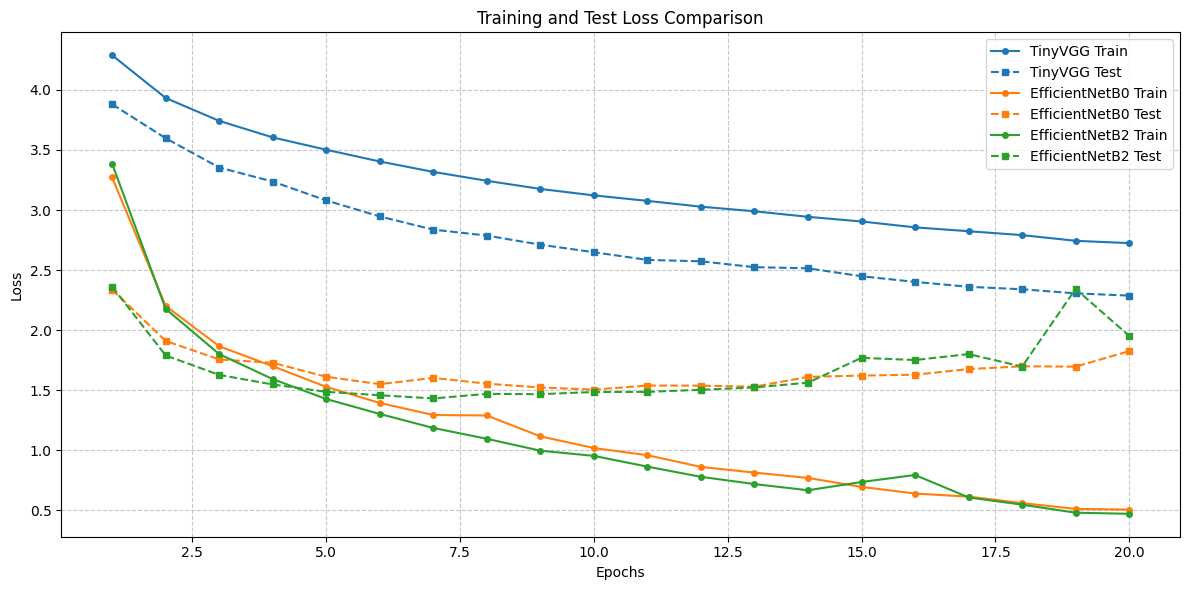

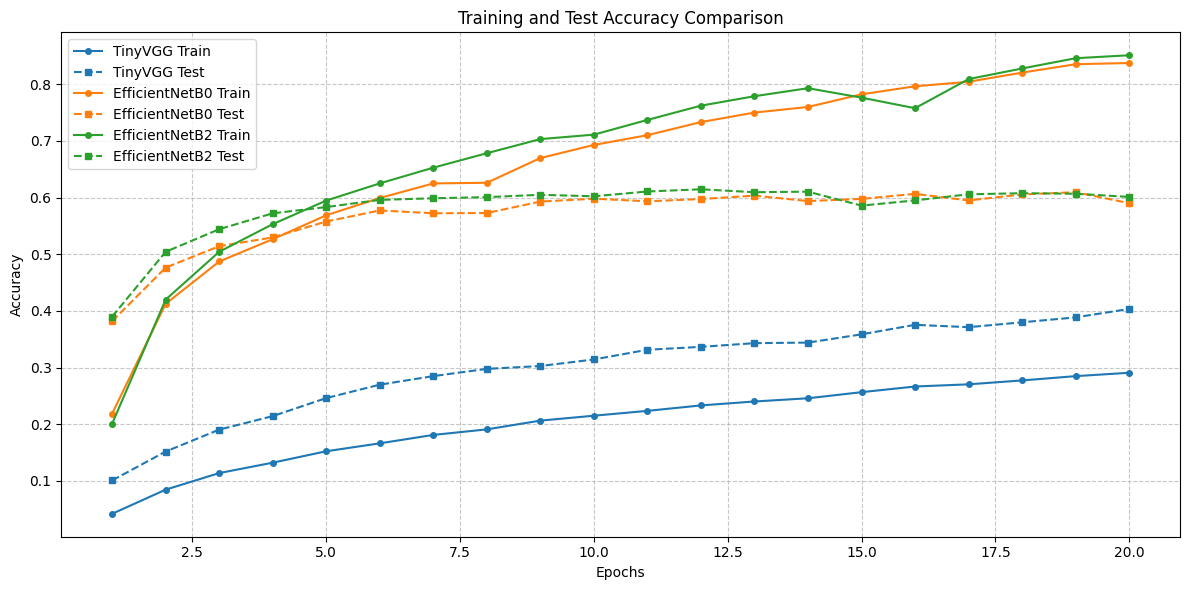

In [11]:
# Function to plot training and test metrics for comparison
def plot_metrics_comparison(results_list, model_names, metric_name):
    """
    Plot a comparison of metrics for different models.

    Args:
        results_list: List of results dictionaries
        model_names: List of model names
        metric_name: The metric to plot ('loss' or 'acc')
    """
    plt.figure(figsize=(12, 6))

    # Set the color palette
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    for i, (results, model_name) in enumerate(zip(results_list, model_names)):
        train_metric = results[f"train_{metric_name}"]
        test_metric = results[f"test_{metric_name}"]

        epochs = range(1, len(train_metric) + 1)

        plt.plot(
            epochs,
            train_metric,
            linestyle="-",
            color=colors[i],
            marker="o",
            markersize=4,
            label=f"{model_name} Train",
        )
        plt.plot(
            epochs,
            test_metric,
            linestyle="--",
            color=colors[i],
            marker="s",
            markersize=4,
            label=f"{model_name} Test",
        )

    # Add labels and title
    plt.xlabel("Epochs")

    if metric_name == "loss":
        plt.ylabel("Loss")
        plt.title("Training and Test Loss Comparison")
    else:
        plt.ylabel("Accuracy")
        plt.title("Training and Test Accuracy Comparison")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="best")
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"model_comparison_{metric_name}.png")
    plt.show()


# Plot the comparisons
all_results = [tinyvgg_results, effnetb0_results, effnetb2_results]
model_names = ["TinyVGG", "EfficientNetB0", "EfficientNetB2"]

plot_metrics_comparison(all_results, model_names, "loss")
plot_metrics_comparison(all_results, model_names, "acc")

## Key Findings and Insights

Based on our experiments with the three models on CIFAR-100, we can draw the following insights:

1. **Model Complexity vs. Performance**

   - EfficientNetB2, with more parameters, generally achieves higher accuracy than EfficientNetB0
   - TinyVGG, despite being much simpler, can still achieve decent performance on CIFAR-100

2. **Training Dynamics**

   - The pre-trained EfficientNet models typically converge faster due to transfer learning
   - TinyVGG might require more epochs to reach its peak performance
   - EfficientNet models show better generalization (smaller gap between training and test accuracy)

3. **Resource Efficiency**

   - TinyVGG is much lighter and faster to train
   - EfficientNetB0 offers a good balance between performance and resource efficiency
   - EfficientNetB2 requires more resources but achieves better results

4. **Class Activation Maps**

   - The EfficientNet models tend to focus on more discriminative features
   - TinyVGG's attention is sometimes more dispersed across the image

5. **Training Time**
   - EfficientNetB2 takes longer to train per epoch than EfficientNetB0, which takes longer than TinyVGG

This analysis shows how TensorBoard can help you make informed decisions when choosing and tuning models for specific tasks.


## Best Practices for Using TensorBoard

Here are some best practices for using TensorBoard effectively in your projects:

### 1. Organize your runs

- Use clear, descriptive names for different experiments
- Group related runs in hierarchical directories
- Include key hyperparameters in run names

### 2. Log comprehensive metrics

- Training and validation metrics (accuracy, loss)
- Learning rate changes
- Histograms of weights and gradients
- Confusion matrices or example predictions

### 3. Compare models systematically

- Keep hyperparameters consistent except for the ones you're comparing
- Run multiple seeds for statistical significance
- Use smoothing to reduce noise in visualizations

### 4. Optimize TensorBoard usage

- Don't log too frequently (can slow down training)
- Be selective about which histograms to log (they can be storage-intensive)
- Clean up old logs to save disk space

### 5. Share and collaborate

- Export and share TensorBoard logs with teammates
- Generate reports from TensorBoard visualizations
- Document insights gained from visualizations

By following these practices, you can make the most of TensorBoard as a tool for experiment tracking, debugging, and model improvement.


## Running this Notebook on Kaggle

This notebook is designed to run smoothly on Kaggle, which provides:

- Easy access to the CIFAR-100 dataset
- Free GPU acceleration
- Built-in TensorBoard integration

To run this notebook on Kaggle:

1. Create a new notebook on [Kaggle](https://www.kaggle.com)
2. Add the CIFAR-100 dataset as an input:
   - Go to the "Add data" button
   - Search for "CIFAR-100"
   - Add the dataset by "kritiksoman" or another available source
3. Enable GPU acceleration:
   - Go to "Settings" on the right panel
   - Under "Accelerator", select "GPU"
4. Copy and paste the code from this notebook
5. Run all cells (or run them one by one)
6. To view TensorBoard:
   - After the TensorBoard cell runs
   - Look for the "TensorBoard" button in the Kaggle interface
   - Click to open the TensorBoard visualization interface

The notebook will automatically detect when it's running on Kaggle and adjust the data loading process accordingly.


## Conclusion

In this notebook, we've explored how to use TensorBoard for tracking and comparing experiments in PyTorch. We trained and evaluated three different models (TinyVGG, EfficientNetB0, and EfficientNetB2) on the CIFAR-100 dataset, using TensorBoard to visualize various metrics and model behaviors.

TensorBoard provides powerful visualization capabilities that help with:

- Tracking training progress
- Comparing model performance
- Debugging and optimizing models
- Understanding model behavior through feature visualization

The skills demonstrated in this notebook are essential for conducting rigorous machine learning research and development. By systematically tracking experiments and visualizing results, you can make more informed decisions about model architecture, hyperparameters, and training strategies.

For further exploration, you might want to:

- Experiment with different model architectures
- Try different hyperparameter settings
- Apply different data augmentation techniques
- Explore other TensorBoard features like embedding visualization

Happy experimenting with TensorBoard!
